# Learning to sort

Can we train a neural network to sort a list of objects, using only constraints that define what it means for the list to be sorted?

Let's see how to do this with `pylon`. To get going, we have the usual preamble.

In [1]:
import torch
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

from pytorch_constraints.constraint import constraint
from pytorch_constraints.sampling_solver import WeightedSamplingSolver

## A model for sorting

Let us now define a model for sorting a list. For a list with $n$ items, the model consists of $n$ decisions: For every item, the model will decide where it should show up in the final ordering. This means that we will have an $n$-way choice per item in the list, parameterized by an $n\times n$ matrix.

In [3]:
class Net(torch.nn.Module):
    def __init__(self, size: int) -> None:
        super().__init__()
        self.size = size
        # first dimension in parameters is the batch, but we won't be using 
        # that. But the solvers assume that the first dimension of logits they 
        # get is the batch dimension. Since the model's forward pass just returns 
        # the logits we will need to  include this in the parameters. It does 
        # not really matter, but thanks to this convention, we will have some 
        # unsightly unsqueezes when we build the loss later.
        self.params = torch.nn.Parameter(torch.rand((1, size, size))) 

    def forward(self, x):
        return self.params

Using a network of this kind, we can sort an array by first finding the location of each element (`argsort`), and then placing each item in the indicated location (`sort`).

In [4]:
def argsort(net, array):
    if len(array) != net.size:
        raise Exception(f"Invalid input. Expecting an array with {net.size} elements. Found {len(array)}.")
    w = net(array)
    return w.squeeze(0).argmax(dim=1).tolist()

def reindex_array(array, indices):
    return [array[i] for i in indices]    

def sort(net, array):
    indices = argsort(net, array)
    return reindex_array(array, indices)

To see this in action, we can take a look at a simple example and the action of a random network on it.

In [5]:
example_array = ['a', 'b', 'c']
example_model = Net(len(example_array))

print(argsort(example_model, example_array))

print(sort(example_model, example_array))

[2, 2, 0]
['c', 'c', 'a']


The `argsort` represents a permutation of the indices of the array. We see that the first index of the `argsort` represents which element of the original array should show up in the first position of  "sorted" array below it. Similarly, every element of the "sorted" array is defined by the index in the `argsort`. Of course, the random network does not sort the array unless we are *extremely* lucky. So what we see here is just a re-ordered array, perhaps with duplicates, rather than a sorted one.

## Defining what sorting means

Let us now define what it means for an array to be sorted. In an array that is sorted in ascending order,
1. For any consecutive pair of items, the first one should be less than the second.
2. The list of indices where the items are to be placed (i.e. the result of `argsort` above) should not have any repetitions.


In [6]:
def is_sorted(array, indices, comparator=lambda a, b: a < b):
    if len(array) < len(indices):
        raise Exception(f"Invalid indices. Expecting at most {len(array)} elements. Found {len(indices)}.")
        
    if not isinstance(indices, list):
        indices = indices.squeeze(0).tolist()

    for index in range(len(indices) - 1):
        if not comparator(array[indices[index]], array[indices[index + 1]]):
            return False
    return True


def has_unique_indices(indices):
    if not isinstance(indices, list):
        indices = indices.squeeze(0).tolist()

    return len(indices) == len(set(indices))

The `is_sorted` function above is just a verbose version of the one used in the [Wikipedia example of bogosort](https://en.wikipedia.org/wiki/Bogosort), a.k.a stupid sort. But unlike bogosort, we will try to guide the shuffler (i.e. the model) towards preferring permutations that sort the array at hand.

### Metrics for tracking model performance

Each of these constraints are Boolean. To get partial credit (so that we can keep track of "how well" a neural network sorts a list), we can implement metrics that measure the degree of satisfaction for each constraint.

To see how well an ordering (i.e. a list of indices) sorts an array, we can measure the number of steps bubble sort will take to put the resulting re-indexed array in the right order. We will normalize this count by the maximum number of swaps possible, i.e. $n \choose 2$. This is essentially equivalent to Kendall's tau. To capture the intuition that higher values are "better", the actual *sort score* is one minus the normalized counts. The lowest value possible is zero, when the array is in descending order, and the highest value is one, when the value is in ascending order.

In [7]:
def sort_score(array, indices, comparator=lambda a, b: a < b):
    # Count the number of bubble sort swaps needed to get to the sorted array.
    new_indices = [i for i in indices]
    swap_count = 0
    num_items = len(indices)

    for i in range(num_items - 1):
        for j in range(num_items - i - 1):
            if not comparator(array[new_indices[j]], array[new_indices[j+1]]):
                tmp = new_indices[j]
                new_indices[j] = new_indices[j+1]
                new_indices[j+1] = tmp
                swap_count +=1

    # normalize the errors to the maximum number of swaps possible to get a 
    # number between zero and one. 
    return 1 - swap_count / (num_items * (num_items - 1)/2)


To see how many repeated indices there are in an `argsort`, we can use the following metric $d_{unique}$ that maps a list of indices $I$ (possibly with repeating elements) to a number between $0$ and $1$:

\begin{align*}
s_{unique}(I) = \frac{|\text{Unique}(I)|-1}{|I|-1} 
\end{align*}

Here, $\text{Unique}$ represents the set containing the elements of the sequence $I$, and $|\cdot|$ represents the number of elements in the argument. The definition above ensures that when all elements of $I$ are unique, the score is one, and in the other extreme, when all elements of $I$ are the same, the score is zero.

In [8]:
def unique_index_score(indices):
    num_indices = len(indices)
    num_unique_indices = len(set(indices))

    return (num_unique_indices - 1) / (num_indices - 1)

## Losses from constraints

We can define losses for the two constraints we defined above. In both cases, `pylon` will help us construct a loss term that uses the predicates (`is_sorted` and `has_unique_indices`) we defined above.

Importantly, both of these loss terms are partial functions that will subsequently take the model's logits to produce the actual loss values.

In [9]:
def sorted_constraint_loss(array):
    return constraint(lambda indices: is_sorted(array, indices), 
                      WeightedSamplingSolver(num_samples=1000))

unique_index_constraint_loss = constraint(has_unique_indices, 
                                     WeightedSamplingSolver(num_samples=1000))


If an array is sorted, then every contiguous sub-sequence in it is also sorted. We can use this observation to help define losses that operate on smaller chunks of an array. 

Given a loss (either the `sorted_constraint_loss` or the `unique_index_constraint_loss`), we can apply it to a sliding window over the array, and accumulate the loss over all such sliding windows. We will call this the *windowed* version of the loss for a given window size.

## Bookkeeping 

At this point, we have all the pieces needed to run experiments and train models. But to see how training proceeds, let us write a few bookkeeping functions. 

It would also be useful to visually inspect a list of arrays. We can show them using a heatmap, where the rows correspond to different orderings.  


In [10]:
def show_array_list(array_list, title):
    fig, ax = plt.subplots(1, 1)
    if isinstance(array_list[0][0], str):
        integers = []
        for array in array_list:
            integers.append(list(map(lambda s: ord(s), array)))
        ax.imshow(np.array(integers), cmap=plt.cm.Oranges)
    else:
        ax.imshow(np.array(array_list), cmap=plt.cm.Oranges)

    for i in range(len(array_list)):
        for j in range(len(array_list[0])):
            ax.text(j, i, array_list[i][j], ha="center", va="center")
    
    ax.tick_params(left=False, labelleft=False)
    ax.set_title(title)
    

To visualize progress during optimization, we can compute the loss and also record it for later plotting. Let us define a helper to update any metadata that we need to keep track of along the way.


In [11]:
class Metadata:
    def __init__(self, array):
        self.array = array
        self.metadata = {
            "orderings": [],
            "scores": {
                "Sort score": [],
                "Unique index score": []
            },
            "losses": {
                "total loss": []
            }        
        }
    
    def record_loss(self, loss_name, value):
        if loss_name not in self.metadata["losses"]:
            self.metadata["losses"][loss_name] = []
        self.metadata["losses"][loss_name].append(value.item())

    def update_metadata(self, model, array):
        indices = argsort(model, array)

        self.metadata["orderings"].append(sort(model, array))

        self.metadata["scores"]["Sort score"].append(sort_score(array, indices))
        self.metadata["scores"]["Unique index score"].append(unique_index_score(indices))
        
    def __plot_helper(self, lines, vertical_axis_label, ylim=None):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.xlabel("Epoch")
        plt.ylabel(vertical_axis_label)
        for key, value in lines.items():
            ax.plot(value, label=key)
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        if ylim is not None:
            ax.set(ylim=ylim)
        fig.canvas.draw()

        
    def display(self):
        self.__plot_helper(self.metadata["losses"], "Loss")
        self.__plot_helper(self.metadata["scores"], "Score", ylim=(-0.1, 1.1))

        show_array_list([self.array], "Original array")
        
        show_array_list(self.metadata["orderings"][0:3],
                       "First three epochs")
        
        show_array_list(self.metadata["orderings"][-3:],
                       "Last three epochs")


Finally, we can write a helper for inspecting an array, and how a list of indices will re-order the elements of the array.

In [12]:
def print_array_diagnostics(array, indices, comparator=lambda a, b: a < b):
    ordered_array = reindex_array(array, indices)
    
    info = [
        ("Original array", array),
        ("Ordered array", ordered_array),
        ("Is sorted?", is_sorted(array, indices, comparator)),
        ("Sort score", sort_score(array, indices, comparator)),
        ("Has unique indices?", has_unique_indices(indices)),
        ("Unique index score", unique_index_score(indices))
    ]
    
    df = pd.DataFrame(map(lambda pair: {"Description": pair[0], "Value": pair[1]}, info))
    display(df)

## Experiments

To get started, let us create helpers to create arrays that will need sorting. We will work with two kinds of arrays: a random array, and an array of letters sorted in  reverse alphabetical order.

In [13]:
def create_random_array(size):
    return np.random.randint(low=1, high=1000, size=size) / 10


def create_letters_array(size):
    letters = list('abcdefghijklmnopqrstuvwxyz')
    result = letters[:size]
    result.reverse()
    return result
    

Now, we can write the training step. This follows the usual pytorch skeleton of iterating the following steps for many epochs:
1. Define the loss
2. Perform the backward pass to compute the gradient
3. Take a gradient step using the optimizer of choice.

Of course, there is bookkeeping code to keep track of things like losses, scores and the ordered arrays themselves. 

The interesting part of this involves the definition of the loss. Unlike the standard supervised scenario, where the loss is defined in terms of a batch of labeled examples, here, we will define the loss using only the constraints. Recall that we don't care for our model to find a generic sorting algorithm. We only want to sort the given array.

The constraint-derived losses defined above can be accumulated to defined the loss. In addition to the array-wide sortedness and uniqueness losses (which we will call *global* losses), we will also measure the same two losses over sliding windows over the array. The intuition is that if the entire array is sorted, every window in it should also be sorted. We can use these windows to provide localized feedback to the optimizer. We will refer to these as the *local* losses.


In [14]:
def train(array, 
          num_epochs=50, 
          use_global_sort_loss=False, 
          use_global_unique_index_loss=False,
          local_sort_loss_windows=[2,3,4],
          local_unique_index_loss_windows=[2,3,4],
          verbose=True,
         ):
    metadata = Metadata(array)
    
    size = len(array)
    model = Net(size)
    
    if verbose:
        print_array_diagnostics(array, argsort(model, array))
    
    optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
    
    
    if verbose:
        epoch_range = tqdm.trange(num_epochs)
    else:
        epoch_range = range(num_epochs)
    
    sort_loss = sorted_constraint_loss(array)
    for epoch in epoch_range:
        optimizer.zero_grad()
        
        # metadata before any updates
        metadata.update_metadata(model, array)
        
        # build up the loss
        prediction = model(array)
        
        total_loss = 0.
        
        if use_global_sort_loss:
            global_sort_loss = sort_loss(prediction)
            metadata.record_loss("global_sort_loss", global_sort_loss)

            # If for some reason, this loss (or any other loss below) is infinite,
            # we will not include it. As a result of this, the loss plot may look 
            # weird with sudden jumps as these terms show up in some epochs and not 
            # others.
            if global_sort_loss < math.inf:
                total_loss += global_sort_loss
            
        if use_global_unique_index_loss:
            global_unique_index_loss = unique_index_constraint_loss(prediction)
            metadata.record_loss("global_unique_index_loss", 
                                 global_unique_index_loss)
            
            if global_unique_index_loss < math.inf:            
                total_loss += global_unique_index_loss
        
        for window_size in local_unique_index_loss_windows:
            if window_size > size:
                continue
                
            window_loss = 0.
            for start in range(size - window_size + 1):
                end = start + window_size
                window_loss += unique_index_constraint_loss(prediction[0][start:end].unsqueeze(0))
                
            metadata.record_loss(f"window_unique_index_loss_{window_size}", window_loss)
            if window_loss < math.inf:
                total_loss += window_loss

        for window_size in local_sort_loss_windows:
            if window_size > size:
                continue            
                
            window_loss = 0.
            for start in range(size - window_size + 1):
                end = start + window_size
                window_loss += sort_loss(prediction[0][start:end].unsqueeze(0))
                
            metadata.record_loss(f"sort_loss_{window_size}", window_loss)
            if window_loss < math.inf:
                total_loss += window_loss
                
        if isinstance(total_loss, float):
            # sometimes, all the losses are infinite, so the total loss is just zero.
            # this means that there is no gradient to speak of.
            # this happens with the sampling based solvers if none of the samples are 
            # informative. In this case, we have to just take the hit and move to the 
            # next iteration
            continue 
        
        metadata.record_loss("total loss", total_loss)

        
        # gradient step
        total_loss.backward()
        optimizer.step()
        
    sorted_array = sort(model, array)
    argsort_indices = argsort(model, array)
    metadata.metadata["orderings"].append(sorted_array)
    
    if verbose:
        print_array_diagnostics(array, argsort(model, array))
    
    return metadata

### Experiment 1: Sorting an array

Using the trainer defined above, we can define our first experiment, where we have to sort one array. This array could be given to the experiment, or it could be randomly generated given a size. By default, we will include both kinds of global losses, and not have any local losses unless explicitly specified.

In [15]:

def experiment(array_size=None, 
               array=None,
               num_epochs=50, 
               sort_window_sizes=[], 
               unique_index_window_sizes=[],
               use_global_sort_loss=True,
               use_global_unique_index_loss=True
              ):
    if array is None and array_size is not None:
        array = create_random_array(array_size)
    
    if array is None:
        raise Exception("Not enough information provided to create an array.")

    result = train(array, 
              num_epochs=num_epochs,
              use_global_sort_loss=use_global_sort_loss, 
              use_global_unique_index_loss=use_global_unique_index_loss,
              local_sort_loss_windows=sort_window_sizes,
              local_unique_index_loss_windows=unique_index_window_sizes)
    
    result.display()



Let us take this for a spin. For starters, let us see whether we can reverse an array of five letters.

,Description,Value
0,Original array,"[e, d, c, b, a]"
1,Ordered array,"[c, b, a, b, e]"
2,Is sorted?,False
3,Sort score,0.4
4,Has unique indices?,False
5,Unique index score,0.75


  0%|          | 0/20 [00:00<?, ?it/s]

,Description,Value
0,Original array,"[e, d, c, b, a]"
1,Ordered array,"[a, b, c, d, e]"
2,Is sorted?,True
3,Sort score,1.0
4,Has unique indices?,True
5,Unique index score,1.0


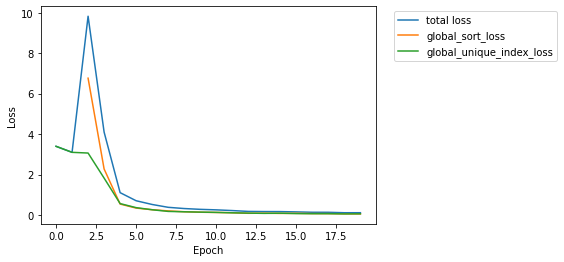

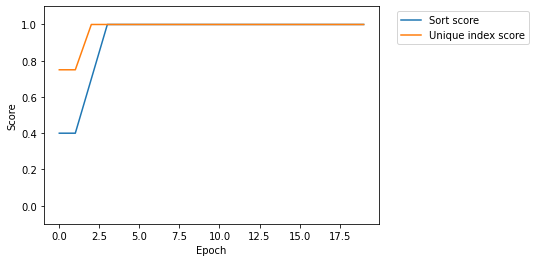

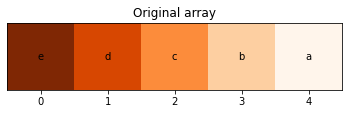

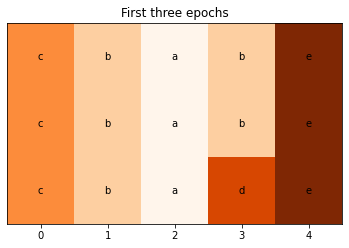

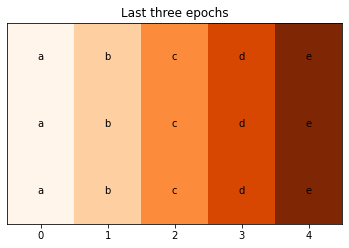

In [16]:
experiment(array=create_letters_array(5),
           num_epochs=20)

,Description,Value
0,Original array,"[0.7, 2.1, 11.3, 83.4, 67.4]"
1,Ordered array,"[67.4, 11.3, 11.3, 67.4, 11.3]"
2,Is sorted?,False
3,Sort score,0.1
4,Has unique indices?,False
5,Unique index score,0.25


  0%|          | 0/20 [00:00<?, ?it/s]

,Description,Value
0,Original array,"[0.7, 2.1, 11.3, 83.4, 67.4]"
1,Ordered array,"[0.7, 2.1, 11.3, 67.4, 83.4]"
2,Is sorted?,True
3,Sort score,1.0
4,Has unique indices?,True
5,Unique index score,1.0


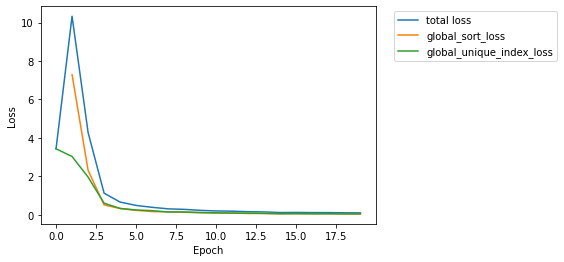

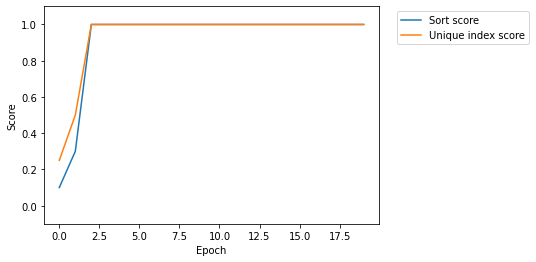

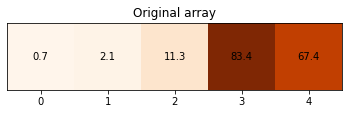

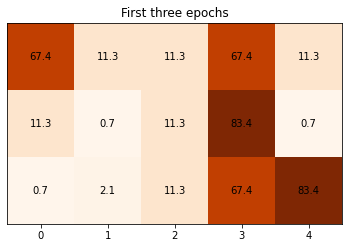

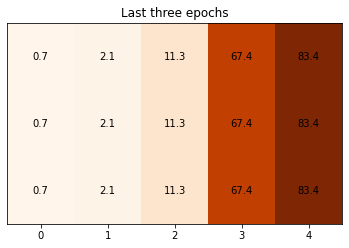

In [17]:
experiment(array_size=5, 
           num_epochs=20)

It appears that with five elements, our model is successful with just the global constraint losses, without help their windowed variants. Let's examine arrays with more elements.

,Description,Value
0,Original array,"[h, g, f, e, d, c, b, a]"
1,Ordered array,"[e, a, e, b, e, e, e, e]"
2,Is sorted?,False
3,Sort score,0.357143
4,Has unique indices?,False
5,Unique index score,0.285714


  0%|          | 0/50 [00:00<?, ?it/s]

,Description,Value
0,Original array,"[h, g, f, e, d, c, b, a]"
1,Ordered array,"[e, g, f, b, c, a, h, d]"
2,Is sorted?,False
3,Sort score,0.428571
4,Has unique indices?,True
5,Unique index score,1.0


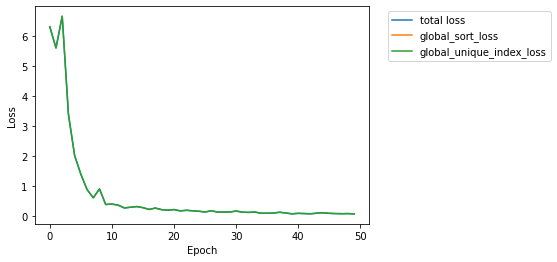

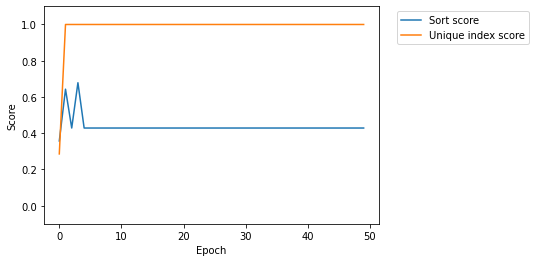

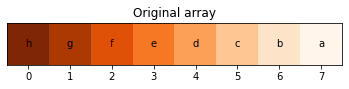

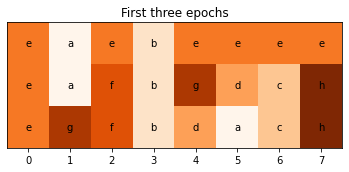

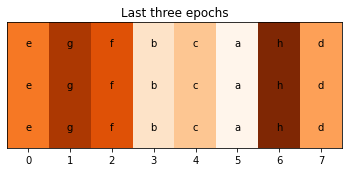

In [18]:
experiment(array=create_letters_array(8),
           num_epochs=50)

That doesn't look too good. We see from the loss plot that the global sort loss never kicked in. Maybe adding local information over windows will help.

,Description,Value
0,Original array,"[h, g, f, e, d, c, b, a]"
1,Ordered array,"[d, g, a, e, b, a, h, c]"
2,Is sorted?,False
3,Sort score,0.392857
4,Has unique indices?,False
5,Unique index score,0.857143


  0%|          | 0/50 [00:00<?, ?it/s]

,Description,Value
0,Original array,"[h, g, f, e, d, c, b, a]"
1,Ordered array,"[a, c, b, d, e, f, g, h]"
2,Is sorted?,False
3,Sort score,0.964286
4,Has unique indices?,True
5,Unique index score,1.0


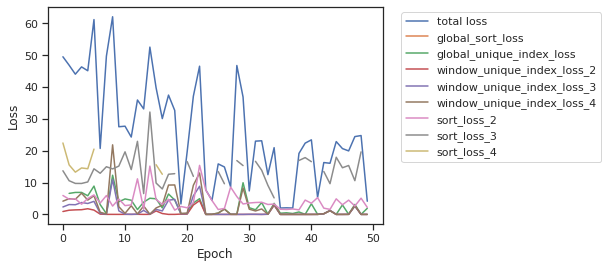

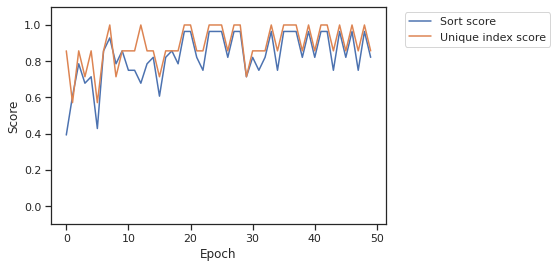

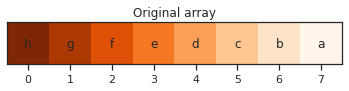

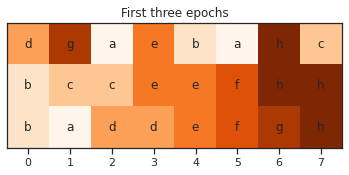

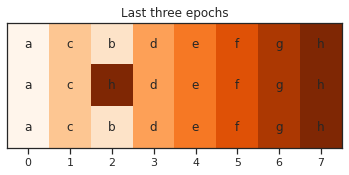

In [27]:
experiment(array=create_letters_array(8),
           num_epochs=50,
           sort_window_sizes=[2, 3, 4],
           unique_index_window_sizes=[2, 3, 4])

It looks like the failures of the global sort constraint can be fixed by localizing the constraint to all sliding windows. Accumulating the losses over windows of size 2, 3 and 4 (almost) takes care of the problem we faced in the previous trial. We will include these windows in all trials below.

,Description,Value
0,Original array,"[0.4, 14.8, 83.7, 54.4, 7.3, 8.8, 51.8, 31.7]"
1,Ordered array,"[0.4, 7.3, 14.8, 51.8, 54.4, 31.7, 51.8, 83.7]"
2,Is sorted?,False
3,Sort score,0.821429
4,Has unique indices?,False
5,Unique index score,0.857143


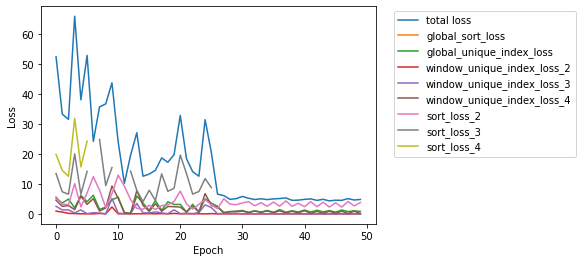

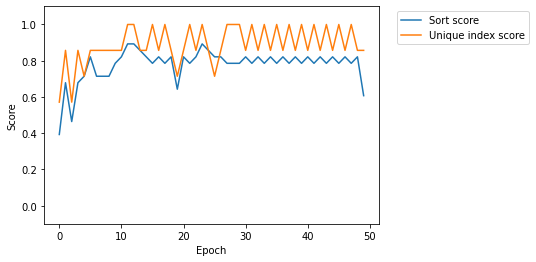

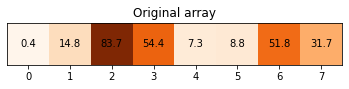

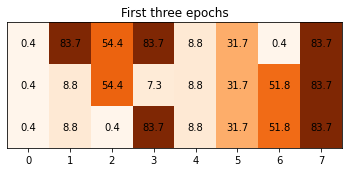

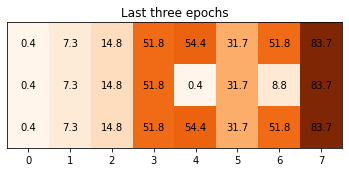

In [20]:
experiment(array_size=8, 
           num_epochs=50,
           sort_window_sizes=[2, 3, 4], 
           unique_index_window_sizes=[2, 3, 4])           

In the randomly initialized array, we see that the sort score improves over the initialization, but the final array is not yet sorted. Let's now examine a larger input.

,Description,Value
0,Original array,"[j, i, h, g, f, e, d, c, b, a]"
1,Ordered array,"[f, f, f, i, f, i, d, a, f, h]"
2,Is sorted?,False
3,Sort score,0.155556
4,Has unique indices?,False
5,Unique index score,0.444444


  0%|          | 0/50 [00:00<?, ?it/s]

,Description,Value
0,Original array,"[j, i, h, g, f, e, d, c, b, a]"
1,Ordered array,"[a, c, d, f, h, i, e, g, h, j]"
2,Is sorted?,False
3,Sort score,0.822222
4,Has unique indices?,False
5,Unique index score,0.888889


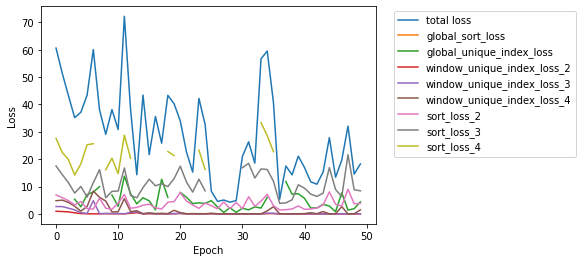

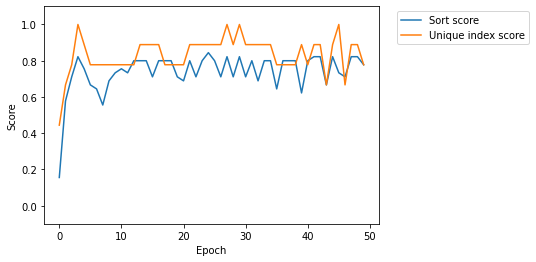

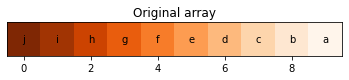

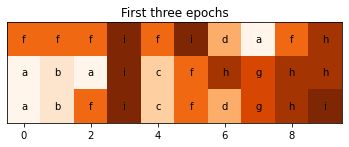

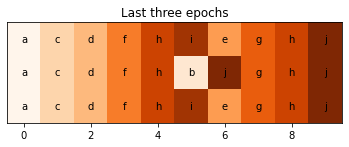

In [21]:
experiment(array=create_letters_array(10),
           num_epochs=50,
           sort_window_sizes=[2, 3, 4],
           unique_index_window_sizes=[2, 3, 4])

This time, the learner seems to be improving, but not quite there, even with the window constraints.

,Description,Value
0,Original array,"[0.3, 23.9, 83.8, 75.7, 36.2, 37.4, 7.4, 32.6,..."
1,Ordered array,"[32.6, 62.3, 93.1, 37.4, 93.1, 37.4, 75.7, 23...."
2,Is sorted?,False
3,Sort score,0.355556
4,Has unique indices?,False
5,Unique index score,0.555556


  0%|          | 0/50 [00:00<?, ?it/s]

,Description,Value
0,Original array,"[0.3, 23.9, 83.8, 75.7, 36.2, 37.4, 7.4, 32.6,..."
1,Ordered array,"[0.3, 37.4, 93.1, 32.6, 36.2, 75.7, 7.4, 23.9,..."
2,Is sorted?,False
3,Sort score,0.6
4,Has unique indices?,True
5,Unique index score,1.0


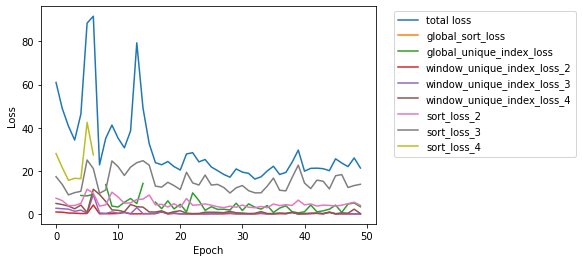

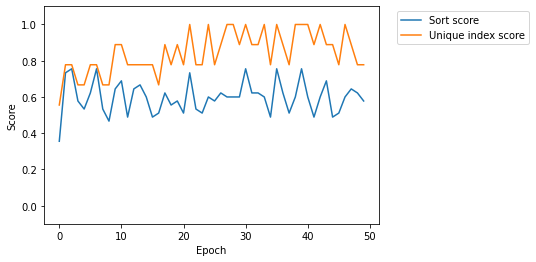

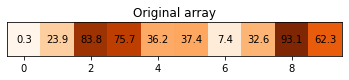

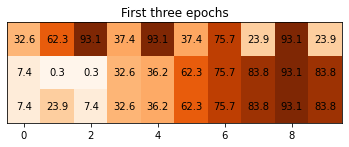

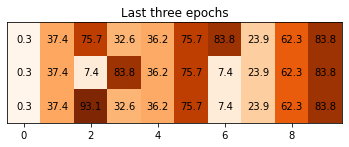

In [22]:
experiment(array_size=10, 
           num_epochs=50,
           sort_window_sizes=[2, 3, 4], 
           unique_index_window_sizes=[2, 3, 4])

### Experiment 2: Sorting performance vs. input size

The trials above suggest that the use of constraint-losses to "define" sorting seems to work perfectly for small arrays, and it takes bigger arrays towards being sorted, but without necessarily getting there. But the above results vary based on the random initialization of the network parameters. To see how robust the sorting is for various input sizes, we will need to do another experiment where we try different random initializations. We will work with letter arrays to avoid a confound from the randomness in the inputs.

In [23]:
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

def size_comparison_experiment(sizes=[4,5,6,7,8,9,10], 
                               num_epochs=50, 
                               num_repeats_per_size=5):
    data = []
    window_sizes = [2,3,4]
    for array_size in tqdm.tqdm(sizes):
        for _ in tqdm.trange(num_repeats_per_size):
            array = create_letters_array(array_size)

            result = train(array, 
                          num_epochs=num_epochs,
                          use_global_sort_loss=True, 
                          use_global_unique_index_loss=True,
                          local_sort_loss_windows=window_sizes,
                          local_unique_index_loss_windows=window_sizes,
                          verbose=False)        
            
            final_sort_score = result.metadata["scores"]["Sort score"][-1]
            final_unique_score =result.metadata["scores"]["Unique index score"][-1]
                    
            data.append({
                "Array size": array_size,
                "Sort score": final_sort_score,
                "Unique index score": final_unique_score,
                
            })
    return pd.DataFrame(data)

In [24]:
sizes = [4,5,6,7,8,9,10]
data = size_comparison_experiment(sizes=sizes)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[(-0.1, 1.1)]

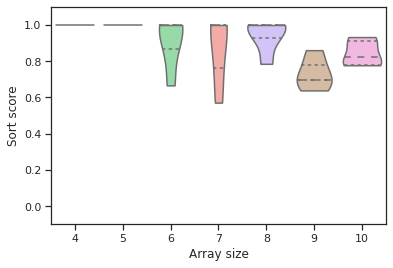

In [25]:
ax = sns.violinplot(data=data,
                    x="Array size", y="Sort score",
                    palette="pastel",
                    cut=0,
                    order=sizes,
                    inner="quartile")
ax.set(ylim=(-0.1, 1.1))

[(-0.1, 1.1)]

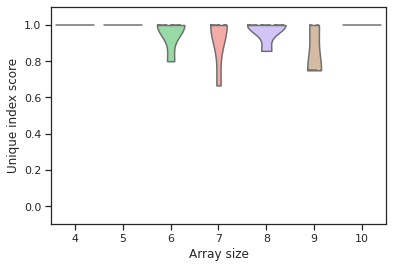

In [26]:
ax = sns.violinplot(data=data,
                    x="Array size", y="Unique index score",
                    palette="pastel",
                    cut=0,
                    order=sizes,
                    inner="quartile")
ax.set(ylim=(-0.1, 1.1))

There's some degradation in performance as the arrays become longer, but recall that the starting point for each case corresponds to arrays in descending order (i.e, with zero sort scores). 

## Final words

There are several factors at play here that we have not considered here. For example, perhaps running the optimizer longer might have done the trick in the cases where the sort and unique index scores are not perfect. Moreover, we have defined "sorting" using two constraints here, but there may be other, perhaps more data-efficient ways of defining sorting. The declarative aspect of `pylon` allows us to explore such definitions without having to think about *how* the losses will actually be implemented. We will leave this exploration as an exercise to the reader.